The code loads SST anomalies data from last tutorial (saved in SST_anomalies_data.mat) then loads the .nc file of gridded monthly temperature data for BC.  Period: Jan 1979 to July 2017.  All the data pre-processing is done below.

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

In [2]:
#load SST data from .csv file and check it out; rows are months, columns are locations
dataSST = pd.read_csv('SST_anomalies_data.csv',header=None)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dataSST.head()
SST_extent=[-360+159.75,-360+260.25,-10.5,10.5] #these are just the known boundaries of the SST grid [lonmin,lonmax,latmin,latmax] for plotting


#load coastline data
coasts = pd.read_csv('coastline.csv',header=None)
coastLat = coasts[0]
coastLon = coasts[1]

In [3]:
#open netcdf file of temperature over BC

filename = 'T_monthly_Canada_1979_2017_ERA_Interim.nc'
dataERA = Dataset(filename)

lonERA = -360+dataERA.variables['longitude'][:] #in degrees E
latERA = dataERA.variables['latitude'][:] #in degrees N
timeERA = dataERA.variables['time'][:] #in hours since year 1900... not a great unit, but it's what ERA comes in
T = dataERA.variables['t2m'] #in K

In [4]:
#reformat data from 3D to 2D, where rows are grid points, columns are months

T2d = np.empty((np.shape(T)[1]*np.shape(T)[2],np.shape(T)[0]))
for ii in range(np.shape(T)[0]):
    T2d[:,ii] = np.reshape(T[ii],(np.shape(T)[1]*np.shape(T)[2],))

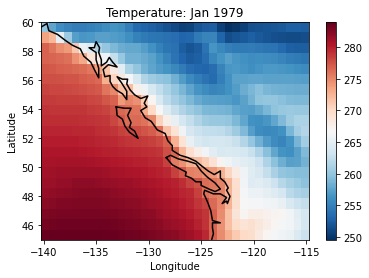

In [5]:
#plot temp over whole domain Jan 1979

lonERAmin = np.min(lonERA)
lonERAmax = np.max(lonERA)
latERAmin = np.min(latERA)
latERAmax = np.max(latERA)
T_extent = [lonERAmin,lonERAmax,latERAmin,latERAmax]
plt.imshow(np.asarray(np.squeeze(T[0,:,:])), extent=T_extent,cmap = 'RdBu_r',aspect='auto')
plt.plot(coastLon,coastLat,c='k')
plt.xlim(T_extent[:2])
plt.ylim(T_extent[2:])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature: Jan 1979')
plt.colorbar()

plt.show()

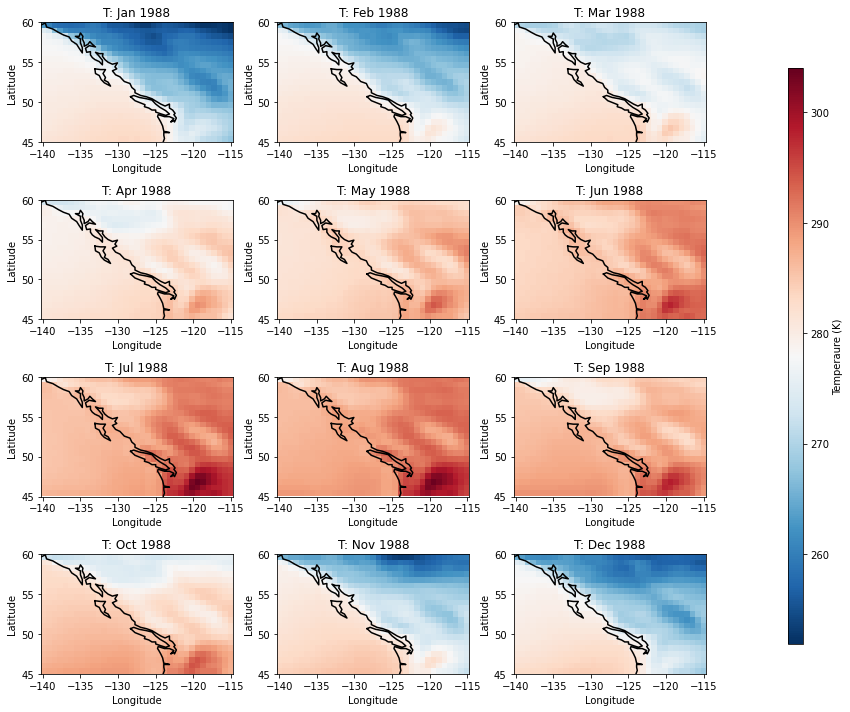

In [6]:
#plot temp for each month in 1988, since this year had a strong La Nina event

vmin = np.min([T[12*9+month,:,:] for month in range(12)])
vmax = np.max([T[12*9+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*9+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1988')
    #plt.colorbar()
    month+=1
 
plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax,label="Temperaure (K)")

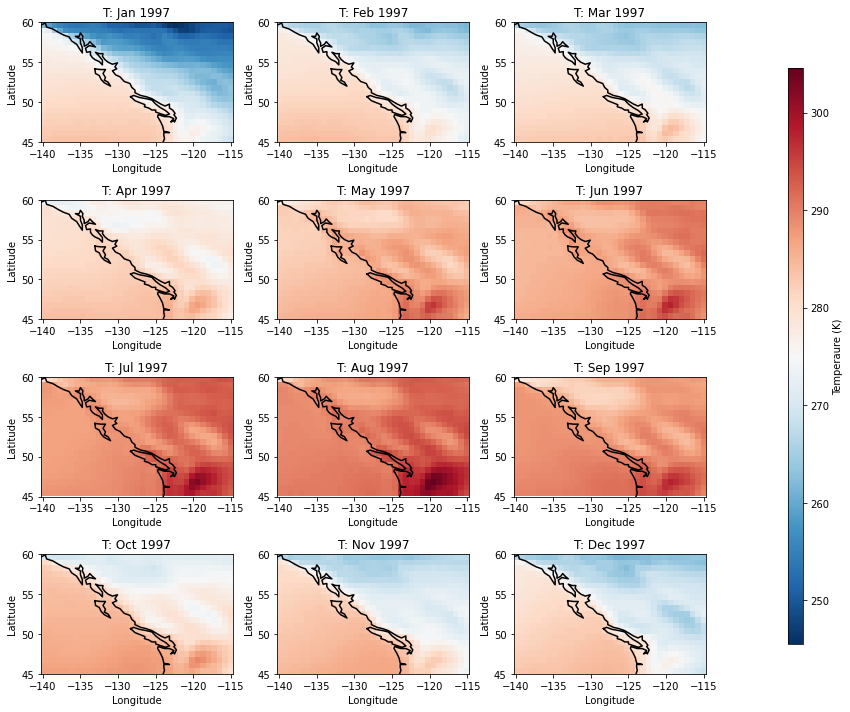

In [7]:
#plot temp for each month in 1997, since this year had a strong El Nino event

vmin = np.min([T[12*18+month,:,:] for month in range(12)])
vmax = np.max([T[12*18+month,:,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.squeeze(T[12*18+month,:,:])), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1
    
plt.tight_layout()    
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax,label="Temperaure (K)")

Preprocessing: remove seasonal cycle and apply 3-month running mean -- we want smoothed anomalies!



In [8]:
#remove last 7 months from 2017, so the timeseries line up
T_cut = T[:-7]
T2d_cut = T2d[:,:-7]

#calculate seasonal signal for each grid point
nyears = 38
T2d_seasonal = np.empty((np.shape(T2d)[0],12))
for ii in range(len(T2d_cut)):
    T2d_seasonal[ii,:] = np.mean(np.reshape(T2d_cut[ii,:],(nyears,12)),axis=0)

#repeat the seasonal cycle for all years
T2d_seasonal_all = np.tile(T2d_seasonal,(1,nyears))

#remove seasonal cycle from the original data (calculate anomalies)
T2d_anomalies = T2d_cut - T2d_seasonal_all

#apply 3-month running mean on each grid point 
T2d_anomalies_smooth = np.empty_like(T2d_anomalies)
N=3 #length of moving window
for ii in range(len(T2d_anomalies)):
    x=T2d_anomalies[ii,:]
    T2d_anomalies_smooth[ii,:] = np.convolve(x, np.ones((N,))/N, mode='same')


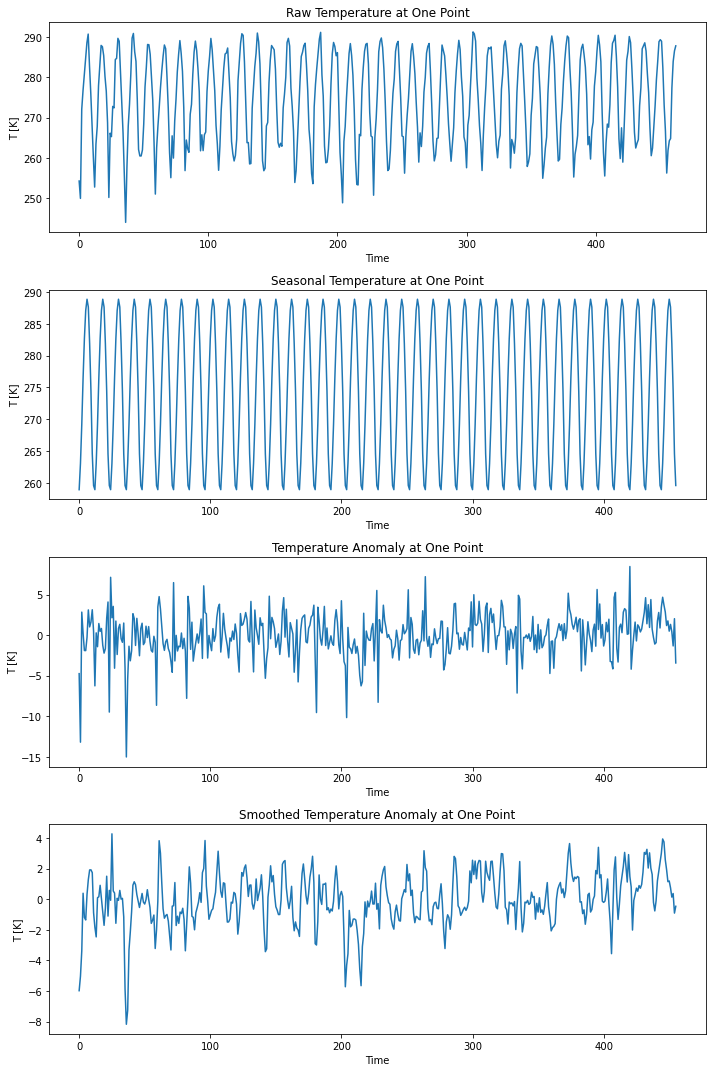

In [9]:
#let's visualize all of these great pre-processing steps!

gridIndex = 50 #arbitrary grid point to visualize the preprocessing for

plt.figure(figsize=(10,15))

plt.subplot(4,1,1)
plt.plot(T2d[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Raw Temperature at One Point')

plt.subplot(4,1,2)
plt.plot(T2d_seasonal_all[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Seasonal Temperature at One Point')

plt.subplot(4,1,3)
plt.plot(T2d_anomalies[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Temperature Anomaly at One Point')

plt.subplot(4,1,4)
plt.plot(T2d_anomalies_smooth[gridIndex,:])
plt.xlabel('Time')
plt.ylabel('T [K]')
plt.title('Smoothed Temperature Anomaly at One Point')

plt.tight_layout()
plt.show()


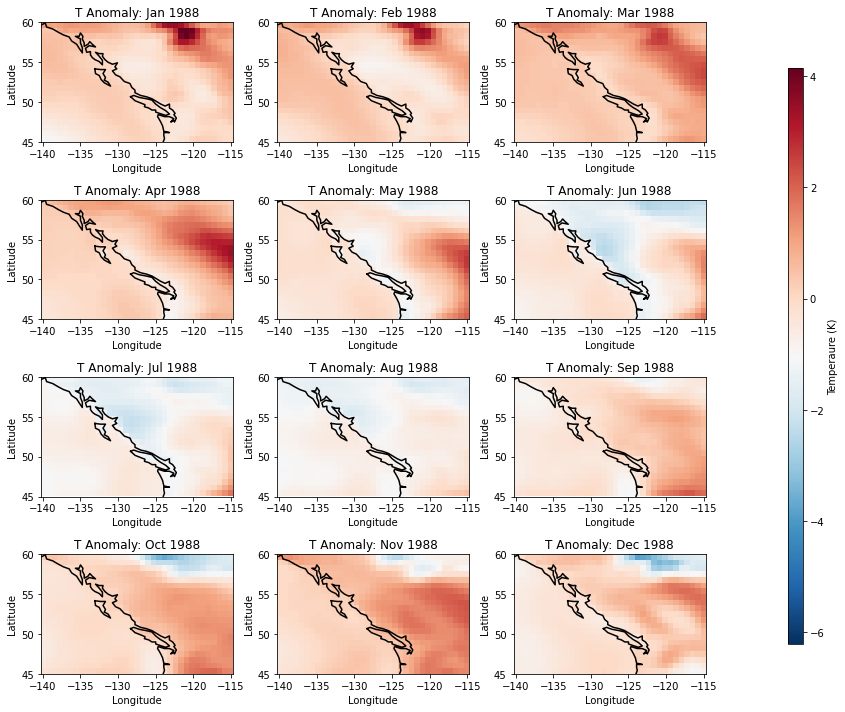

In [10]:
#plot the 3-month running mean of residuals for all grid points for all months of 1988

vmin = np.min([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*9+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    #ax.set_axis_off()
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*9+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1988')
    month+=1
    
plt.tight_layout()   
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax,label="Temperaure (K)")

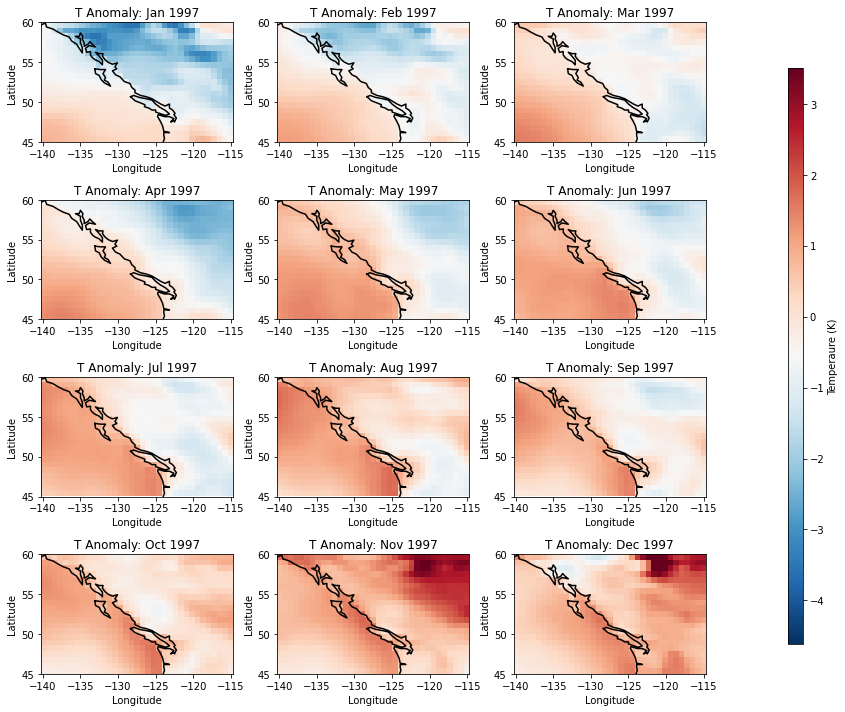

In [11]:
#plot the 3-month running mean of residuals for all grid points for all months of 1997

vmin = np.min([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])
vmax = np.max([T2d_anomalies_smooth[12*18+month,:] for month in range(12)])

fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))

month = 0
for ax in axes.flat:
    im = ax.imshow(np.asarray(np.reshape(T2d_anomalies_smooth[:,12*18+month],(21,35))), extent=T_extent,cmap = 'RdBu_r',vmin=vmin,vmax=vmax,aspect='auto')
    ax.plot(coastLon,coastLat,c='k')
    ax.set_xlim(T_extent[:2])
    ax.set_ylim(T_extent[2:])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('T Anomaly: ' + months[month] +' 1997')
    #plt.colorbar()
    month+=1

plt.tight_layout()
cb_ax = fig.add_axes([1.1, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax,label="Temperaure (K)")

SOLUTIONS